# Lesson 03
# Peter Lorenz

## 0. Preliminaries
First import the required libraries:

In [169]:
import numpy as np
import pandas as pd

from matplotlib import cm
from matplotlib import colors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt

Check pandas version:

In [3]:
print("Pandas version: " + pd.__version__)

Pandas version: 1.0.3


Set some global options:

In [6]:
# Display plots inline
%matplotlib inline

# Display multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Suppress scientific notation
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Utility and convenience functions:

In [196]:
# Principal components analysis of axes of variation for k-means clustering
def analyze_pca(df, index, components, explained_variance_ratio):
    print('Principal Component ' + str(index + 1) + ':')
    print('Percent of variance explained is ' + \
          str((explained_variance_ratio[index]*100).round(2)) + '%')
    print('')
    
    pc_df = pd.DataFrame({'score':components[index], 'feature':df.columns})
    pc_df = pc_df.sort_values('score')
    print('Principal component ' + str(index + 1) + \
          ', least and most significant features by score:')
    print('Least significant feature(s) (negative end of axis of variation)')
    print(pc_df.iloc[0:1])
    print('')

    print('Most significant feature(s) (positive end of axis of variation)')
    print(pc_df.iloc[-1:])
    print('')
    print('')

# Utility function to convert arbitrary hex color values to color names, used for k-means plotting
# There is no attempt at a general solution: add additional colors as needed
# The current colors derive from matplotlib's 'rainbow' color map normalized to particular number of clusters to render
def color_name_from_rainbow_color_map(hex_value):
    if hex_value == '#8000ff':
        return 'violet'
    if hex_value == '#1996f3':
        return 'blue'
    if hex_value == '#80ffb4':
        return 'sea green'
    if hex_value == '#b2f396':
        return 'yellow-green'
    if hex_value == '#ff964f':
        return 'orange'
    if hex_value == '#ff0000':
        return 'red'

## 1. Read Data

Next import the data set:

In [47]:
# Internet location of the data set
url = "https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/SuperstoreTransaction.csv"

# Download the data into a dataframe object
transaction_data = pd.read_csv(url)

# Display shape and initial data
transaction_data.shape
transaction_data.head()

(9994, 21)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.960,2,0.000,41.914
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.940,3,0.000,219.582
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.000,6.871
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.577,5,0.450,-383.031
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2,0.200,2.516


Note that there are 9994 transactions in the data set and 21 columns.

## 2. Calculate the Recency, Frequency, Monitory for each customer

In this section, we compute the *recency*, *frequency*, and *monitory* for each customer. First we check the data types of the columns in our data set to determine whether any data type conversions are necessary:

In [48]:
# Display info for each column including data type
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

Our date features appear to be represented in the data set as strings, so we convert them to the datetime data type:

In [49]:
# Convert date columns to datetime data type
transaction_data['Order Date'] = pd.to_datetime(transaction_data['Order Date'],
                                                format = '%m/%d/%Y')
transaction_data['Ship Date'] = pd.to_datetime(transaction_data['Ship Date'],
                                               format = '%m/%d/%Y')

Because the transactions in the data set represent transactions rather than daily spending, we must perform aggregation on the individual transactions to obtain daily spending data per customer. We use the date of the order rather than the ship date as the date on which the transaction occurred:

In [182]:
# Aggregate transaction data per customer per day and reset the index
transaction_agg = transaction_data.groupby(['Customer ID', 
                                            'Order Date'], as_index=False).agg({'Sales': 'sum', 
                                                                                'Quantity': 'sum'})
transaction_agg.reset_index()

# Diagnostic output
transaction_agg.shape
transaction_agg.dtypes

,index,Customer ID,Order Date,Sales,Quantity
0,0,AA-10315,2014-03-31,726.548,4
1,1,AA-10315,2014-09-15,29.500,5
2,2,AA-10315,2015-10-04,26.960,2
3,3,AA-10315,2016-03-03,4406.072,14
4,4,AA-10315,2017-06-29,374.480,5
...,...,...,...,...,...
4987,4987,ZD-21925,2014-08-27,244.760,9
4988,4988,ZD-21925,2016-04-03,331.080,8
4989,4989,ZD-21925,2016-05-05,16.720,5
4990,4990,ZD-21925,2016-07-08,839.944,7


(4992, 4)

Customer ID            object
Order Date     datetime64[ns]
Sales                 float64
Quantity                int64
dtype: object

Note that the number of rows in the data set has decreased from 9994 to 4992 as individual transactions have been consolidated into customer daily spending.

Now we compute the rolling features from the aggregated data:

In [183]:
# Compute rolling features
roll_sum = transaction_agg.groupby('Customer ID').rolling(window = '7D',
                                                          on = 'Order Date')['Sales'].sum()
roll_cnt = transaction_agg.groupby('Customer ID').rolling(window = '7D',
                                                          on = 'Order Date')['Quantity'].sum()
roll_min = transaction_agg.groupby('Customer ID')['Order Date'].diff(periods = 1)

Next we combine these rolling features into a new data frame:

In [184]:
# Create new dataframe for rolling features
transaction_roll = pd.concat([roll_sum, roll_cnt], axis = 1)
transaction_roll.columns = ['sales_roll_sum_7D', 'quantity_roll_sum_7D']
transaction_roll = transaction_roll.reset_index()
transaction_roll['last_visit_ndays'] = roll_min.fillna(pd.Timedelta('100 days'))

To view the results, we combine the aggregated data with the rolling data:

In [185]:
# Combine aggregated data with rolling data
transaction_all = transaction_agg.merge(transaction_roll,
                                        how = "inner", 
                                        on = ['Customer ID', 'Order Date'], 
                                        validate = 'one_to_one')
transaction_all.head()

,Customer ID,Order Date,Sales,Quantity,sales_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,AA-10315,2014-03-31,726.548,4,726.548,4.000,100 days
1,AA-10315,2014-09-15,29.500,5,29.500,5.000,168 days
2,AA-10315,2015-10-04,26.960,2,26.960,2.000,384 days
3,AA-10315,2016-03-03,4406.072,14,4406.072,14.000,151 days
4,AA-10315,2017-06-29,374.480,5,374.480,5.000,483 days


In the above output, *recency* is found in the *last_visit_ndays* column, *frequency* is found in the *quantity_roll_sum_7D* column, and *monetary* is found in the *sales_roll_sum_7D* column.

## 3. Using K-means algorithm, perform customer segmentation

In this section, we perform customer segmentation using the k-means algorithm. First we convert the timedelta data type of *last_visit_ndays* to integer so we can aggregate it:

In [186]:
# Convert timedelta to integer for aggregation by mean
transaction_all['last_visit_ndays_int'] = transaction_all['last_visit_ndays'].dt.days

Now we aggregate the RFM data computed in the previous section by customer. For *sales_roll_sum_7D* and *quantity_roll_sum_7D* we aggregate by the median to prevent large orders from unduly influencing the typical value. For *last_visit_ndays_int* we aggregate by the mean:

In [187]:
# Aggregate RFM data per customer and reset the index
rfm_agg = transaction_enc.groupby(['Customer ID'],
                                  as_index=False).agg({'sales_roll_sum_7D': 'median',
                                                       'quantity_roll_sum_7D': 'median',
                                                       'last_visit_ndays_int': 'mean'})
rfm_agg.reset_index()

# Diagnostic output
rfm_agg.shape

,index,Customer ID,sales_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays_int
0,0,AA-10315,374.480,5.000,257.200
1,1,AA-10375,56.860,5.000,158.889
2,2,AA-10480,308.490,9.000,294.250
3,3,AA-10645,717.165,11.500,222.000
4,4,AB-10015,309.592,4.000,365.333
...,...,...,...,...,...
788,788,XP-21865,186.540,8.000,136.091
789,789,YC-21895,750.680,5.000,247.000
790,790,YS-21880,457.500,6.000,146.750
791,791,ZC-21910,148.884,7.000,93.846


(793, 4)

After aggregating the RFM data set per customer, we now have 793 rows, one per customer with RFM values aggregated for median *sales_roll_sum_7D*, median *quantity_roll_sum_7D*, and mean *last_visit_ndays_int*.

To perform K-means clustering we have to set aside the *Customer ID* column and keep the numeric and encoded fields:

In [188]:
# Set aside customer ID's in an array
customer_ids = np.array(rfm_agg['Customer ID'].values)

# Drop customer ID from the data set to keep only numeric columns
rfm_agg = rfm_agg.drop(['Customer ID'], axis=1)

# Display updated data set
rfm_agg.head()

,sales_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays_int
0,374.480,5.000,257.200
1,56.860,5.000,158.889
2,308.490,9.000,294.250
3,717.165,11.500,222.000
4,309.592,4.000,365.333


Next we scale the dataframe between 0 and 1:

In [189]:
# Scale data between 0 and 1
scaler = MinMaxScaler()
rfm_agg = pd.DataFrame(scaler.fit_transform(rfm_agg), columns=rfm_agg.columns)

# Display scaled data set
rfm_agg.head()

,sales_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays_int
0,0.142,0.150,0.324
1,0.021,0.150,0.170
2,0.117,0.350,0.382
3,0.272,0.475,0.269
4,0.117,0.100,0.494


Here we use a function to determine a suitable number of clusters using the "elbow" method:

Text(0.5, 0, 'k')

Text(0, 0.5, 'Sum of squared distances')

Text(0.5, 1.0, 'Elbow Method For Optimal k')

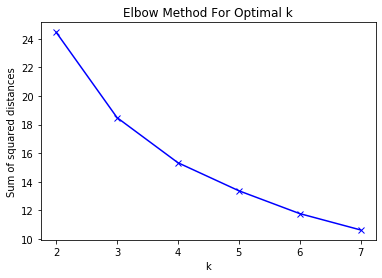

In [190]:
# Compute sums of squares per number of clusters for plotting "elbow"
sum_of_sqs = []
K = range(2,8)
for k in K:
    km = KMeans(n_clusters=k).fit(rfm_agg)
    sum_of_sqs.append(km.inertia_)

# Display "elbow" plot
plt.plot(K, sum_of_sqs, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The "elbow" appears at 3 clusters, so we choose 3 as our number of clusters for segmentation:

In [191]:
# Set number of clusters based on "elbow" method
CLUSTERS = 3

Now we perform K-means clustering and extract the cluster assignments:

In [192]:
# Fit K-means clusters to aggregated RFM data per customer
kmeans = KMeans(init='k-means++', n_clusters=CLUSTERS).fit(rfm_agg)

# Assign clusters per customer
classes = kmeans.predict(rfm_agg)

To interpret the results, we examine the principal components:

In [193]:
# Perform PCA decomposition on the K-means data set
pca = PCA(n_components=len(rfm_agg.columns))
pc = pca.fit_transform(rfm_agg)

# Extract the explained variance per component
explained_variance_ratio = np.sort(np.array(pca.explained_variance_ratio_))[::-1]

Display the explained variance for each of the three resulting components:

In [197]:
# First component
analyze_pca(rfm_agg, 0, pca.components_, explained_variance_ratio)

# Second component
analyze_pca(rfm_agg, 1, pca.components_, explained_variance_ratio)

# Third component
analyze_pca(rfm_agg, 2, pca.components_, explained_variance_ratio)

Principal Component 1:
Percent of variance explained is 52.81%

Principal component 1, least and most significant features by score:
Least significant feature(s) (negative end of axis of variation)
   score               feature
2 -0.020  last_visit_ndays_int

Most significant feature(s) (positive end of axis of variation)
   score               feature
1  0.932  quantity_roll_sum_7D


Principal Component 2:
Percent of variance explained is 35.06%

Principal component 2, least and most significant features by score:
Least significant feature(s) (negative end of axis of variation)
   score               feature
1 -0.025  quantity_roll_sum_7D

Most significant feature(s) (positive end of axis of variation)
   score               feature
2  0.993  last_visit_ndays_int


Principal Component 3:
Percent of variance explained is 12.12%

Principal component 3, least and most significant features by score:
Least significant feature(s) (negative end of axis of variation)
   score               f

The first component accounts for just of 50% of the variance, while the second and third components account for 35% and 12% of the variance respectively. The most significant feature for the first component is the rolling quantity figure (*frequency*), while the most significant features for the second and third components are the number of days since the last sale (*recency*) and rolling sales (*monetory*).

Now we plot our clusters against the first two principal components, indicating clusters by color: 

Text(0.5, 0, 'Principal Component 1')

Text(0, 0.5, 'Principal Component 2')

Text(0.5, 0.98, 'Clusters by Color - Principal Components 1 and 2')

Text(0.5, 1.0, '(K = 3, with dimensionality reduction)')

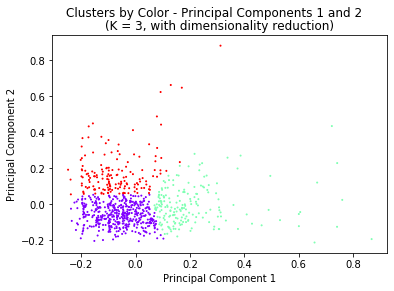

In [198]:
# Plot the cluster against the first two principal components
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.suptitle('Clusters by Color - Principal Components 1 and 2')
plt.title('(K = ' + str(CLUSTERS) + ', with dimensionality reduction)')
plt.scatter(pc[:, 0], pc[:, 1], c=classes, s=1, cmap='rainbow')
plt.show()

Note: there may be some variability between K-means runs! The cluster boundaries are not clearly differentiated, though the cluster with high rolling quantity (principal component 1) shows more separation. Customers are partitioned three ways according to their rolling quantity figure (principal component 1) and recency values (principal component 2). As recency decreases (PC2), the clusters become more diffuse.

Next we examine the centroids of each cluster and their properties:

In [201]:
# Identify colors in k-means plot
norm = mpl.colors.Normalize(vmin=0, vmax=CLUSTERS-1)
cmap = cm.rainbow
smappable = cm.ScalarMappable(norm=norm, cmap=cmap)

# Display the centroids and their properties
points, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, rfm_agg)
i = 0
for point in range(len(points)):
    
    print('CLUSTER ' + str(i + 1) + ' CENTER: ', customer_ids[points[point]])
    print('Rolling sales:    ', str(round(rfm_agg['sales_roll_sum_7D'].values[points[point]], 1)))
    print('Rolling quantity: ', str(round(rfm_agg['quantity_roll_sum_7D'].values[points[point]], 1)))
    print('Recency:          ', str(round(rfm_agg['last_visit_ndays_int'].values[points[point]], 1)))
    print('Color of points:  ', 
          color_name_from_rainbow_color_map(colors.rgb2hex(smappable.to_rgba(i))))
    print('')

    i = i + 1

CLUSTER 1 CENTER:  DN-13690
Rolling sales:     0.1
Rolling quantity:  0.2
Recency:           0.2
Color of points:   violet

CLUSTER 2 CENTER:  JS-15880
Rolling sales:     0.1
Rolling quantity:  0.4
Recency:           0.2
Color of points:   sea green

CLUSTER 3 CENTER:  PC-18745
Rolling sales:     0.0
Rolling quantity:  0.2
Recency:           0.4
Color of points:   red



Examination of the cluster centroids reveals that rolling quantity and recency are the predominent distinguishing features the groups, while rolling sales is fairly neutral. The most important contributing feature to our customer segmentation is rolling weekly quantity.

## 4. Describe your results

After loading the data set (Part 1), the results of Part 2 consisted of a new data set of aggregated sales, quantity, and recency figures derived from individual transactions by customer and order date. The results of Part 2 were then used in Part 3 to perfom a segmentation analysis by customer.

The first part of the segmentation analysis required us to aggregate the RFM results from Part 2 by customer. The following three features were used for customer segmentation:
1. *monetary* represented by the *sales_roll_sum_7D* column
1. *frequency* represented by the *quantity_roll_sum_7D* column
1. *recency* represented by the *last_visit_ndays* column

The second part of the segmentation analysis was to perform K-means clustering on the RFM data set aggregated by customer. We found three clusters to be the optimal division of clusters by the "elbow" method.

Part 3 of the segmentation analysis consisted of an analysis of the principal components of the RFM data set aggregated by customer in which we plotted the clusters against the first two principal components. The first principal component was found to account for just over 50% of the variance in the data set (52%), while the second and third principal components accounted for 35% and 12% of variance respectively. The most significant feature along the first principal component was rolling quantity (*frequency*), while the most significant feature along the second component was days between sales (*recency*). Rolling sales (*monetory*) appears fairly neutral in determining customer segment.

In sum, we found that cluster boundaries were not clearly differentiated, though the cluster representing customers with high rolling quantity (along principal component 1) did reveal some separation. As noted above, customers are partitioned three ways according to their rolling quantity figure (principal component 1) and recency values (principal component 2). As recency decreases (PC2), the clusters become more diffuse.